## import dataset and cleaning

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv("../data/orders.csv")
df.describe()

,reservation_id,brand_id,hotel_id,room_qty,total_price,prepaid
count,53612.000000,53612.000000,53612.000000,53612.000000,53612.000000,53612.000000
mean,26805.500000,8.040084,22.436059,2.807692,24162.838637,16912.530889
std,15476.595653,4.319821,29.229847,2.281995,12957.307979,12367.648322
min,0.000000,1.000000,1.000000,1.000000,2000.000000,0.000000
25%,13402.750000,4.000000,2.000000,1.000000,13053.750000,5775.000000
50%,26805.500000,8.000000,8.000000,2.000000,24063.000000,14920.500000
75%,40208.250000,12.000000,32.000000,4.000000,35063.250000,26535.000000
max,53611.000000,15.000000,120.000000,10.000000,58479.000000,56919.000000


In [61]:
df.head()

,reservation_id,brand_id,hotel_id,reservation_no,room_qty,total_price,prepaid,email,order_date,checkin_date,checkout_date,cancel_date,payment_type
0,0,14,61,TKAI8WWXPDC8M,7,34427,6699,jamespowell@example.org,2025-05-11 01:19:24.064059,2025-08-22,2025-08-23,2025-08-06 01:19:24.064059,Bank Transfer
1,1,12,35,TAY7J2DJ3W8MV,3,5572,2205,jessicathomas@example.org,2025-04-13 07:47:48.819576,2025-05-27,2025-05-29,1900-01-01 00:00:00,On-site
2,2,14,7,TLPYNEXE23MRL,2,21809,17925,allenadrian@example.org,2025-01-12 10:46:14.804832,2025-01-21,2025-01-25,1900-01-01 00:00:00,Bank Transfer
3,3,8,45,TWYRHGFZTD5T3,1,32085,29353,megan35@example.net,2025-09-24 11:21:47.034500,2025-10-01,2025-10-04,1900-01-01 00:00:00,Credit Card
4,4,12,7,TWF9LH9YAR2YB,10,29618,1991,daniel47@example.org,2025-05-16 01:00:31.311268,2025-08-03,2025-08-05,2025-05-27 01:00:31.311268,Credit Card


In [62]:
# verify it's close to our mock script
freq_dist = df['email'].value_counts().value_counts(normalize=True).sort_index()
print(freq_dist)

count
1      0.792794
2      0.136659
3      0.038207
4      0.013402
5      0.007124
6      0.003639
7      0.002768
8      0.001179
9      0.000820
10     0.000666
11     0.000641
12     0.000589
13     0.000077
14     0.000026
15     0.001204
16     0.000128
18     0.000026
21     0.000026
101    0.000026
Name: proportion, dtype: float64


In [63]:
# breakdown order date
df["order_date"] = pd.to_datetime(df["order_date"])
df['order_month'] = df['order_date'].dt.month
df['order_day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = (df['order_date'].dt.dayofweek >= 5).astype(int)
# for stay duration
df["checkin_date"] = pd.to_datetime(df["checkin_date"])
df["checkout_date"] = pd.to_datetime(df["checkout_date"])
# check if cancelled
df['is_cancelled'] = (df['cancel_date'] != "1900-01-01 00:00:00").astype(int)
# 
df['customer_order_count'] = df.groupby('email')['email'].transform('count')
df["lead_time"] = (df["checkin_date"] - df["order_date"]).dt.days
df["stay_duration"] = (df["checkout_date"] - df["checkin_date"]).dt.days
df["price_per_room"] = df["total_price"] / (df["room_qty"]*df["stay_duration"])
df["deposit_ratio"] = df["prepaid"] / df["total_price"]
df["deposit_ratio"] = df["deposit_ratio"].clip(0, 1)
df["group_size"] = df["room_qty"]
# cleanup
# email was dropped here, it was replaced by customer_order_count
df.drop('reservation_id', axis=1, inplace=True)
df.drop('reservation_no', axis=1, inplace=True)
df.drop('email', axis=1, inplace=True)
df.drop('order_date', axis=1, inplace=True)
df.drop('checkin_date', axis=1, inplace=True)
df.drop('checkout_date', axis=1, inplace=True)
df.drop('cancel_date', axis=1, inplace=True)
df.drop('room_qty', axis=1, inplace=True)

df.columns

Index(['brand_id', 'hotel_id', 'total_price', 'prepaid', 'payment_type',
       'order_month', 'order_day_of_week', 'is_weekend', 'is_cancelled',
       'customer_order_count', 'lead_time', 'stay_duration', 'price_per_room',
       'deposit_ratio', 'group_size'],
      dtype='object')

In [65]:
def check_tier(row):
    if row['group_size'] >= 5: return 'High Risk (15%)'
    if 3 <= row['group_size'] <= 4: return 'Medium Risk (20%)'
    return 'Normal (65%)'

tier_verification = df.apply(check_tier, axis=1).value_counts(normalize=True)
print(tier_verification)

Normal (65%)         0.651216
Medium Risk (20%)    0.197008
High Risk (15%)      0.151776
Name: proportion, dtype: float64


## analyze dataset

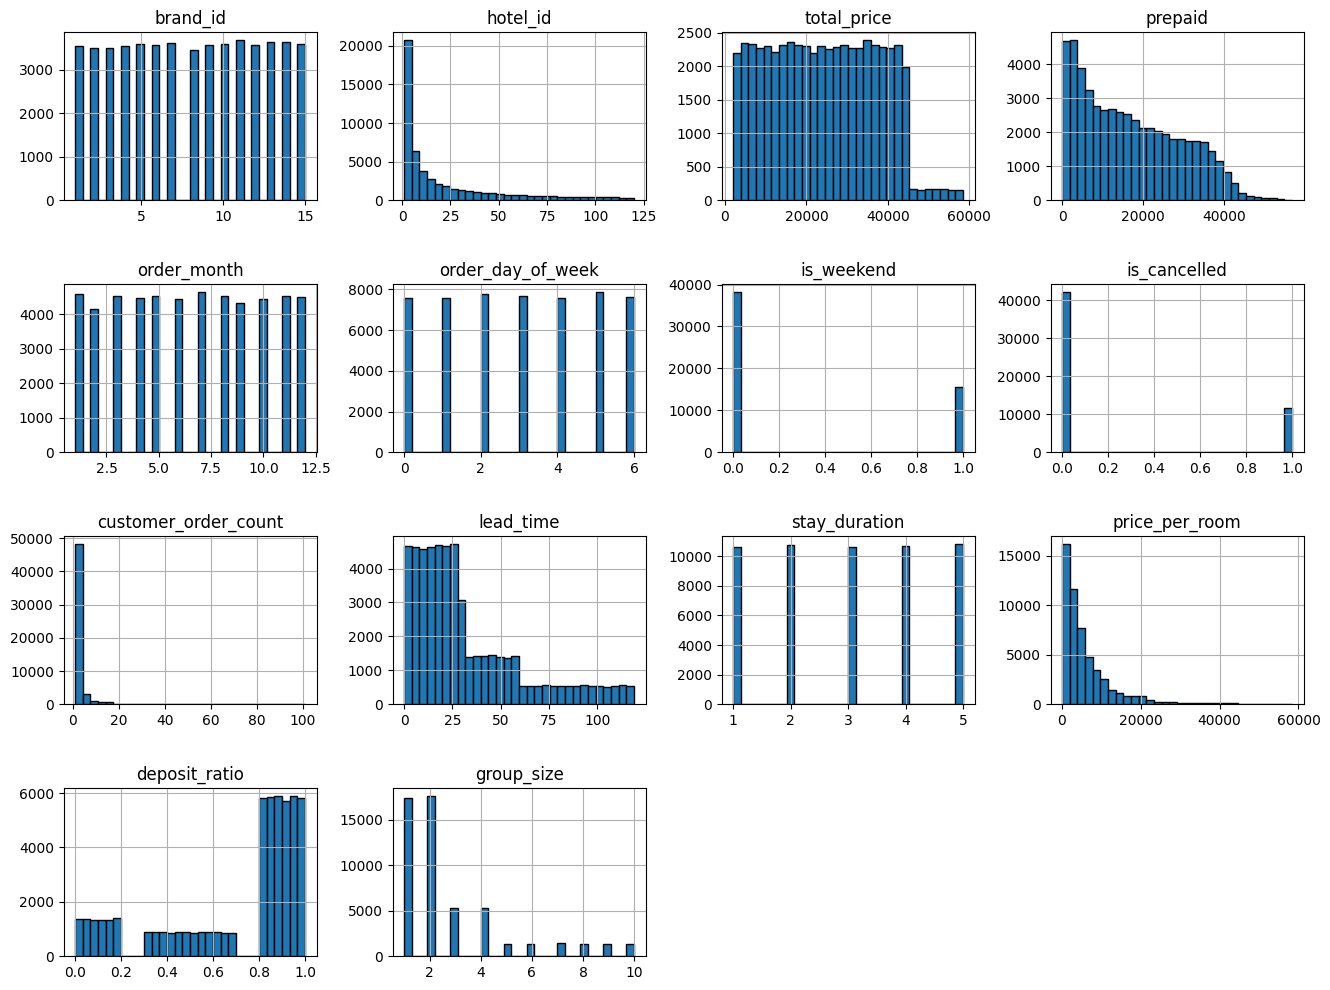

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot all numerical distributions
df.hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.subplots_adjust(hspace=0.5)
plt.show()

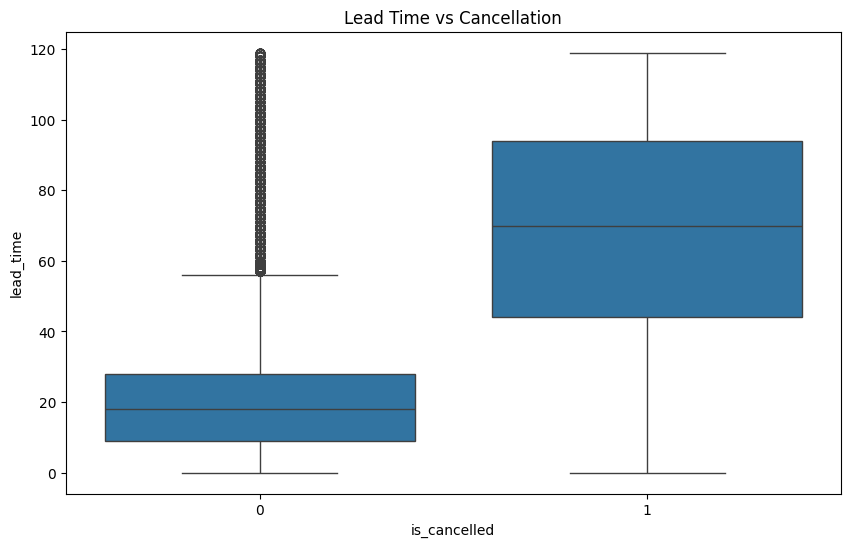

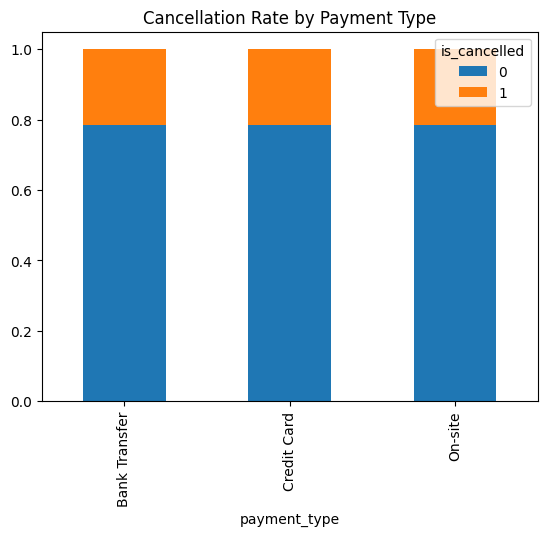

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='is_cancelled', y='lead_time')
plt.title('Lead Time vs Cancellation')
plt.show()

pd.crosstab(df['payment_type'], df['is_cancelled'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Cancellation Rate by Payment Type')
plt.show()

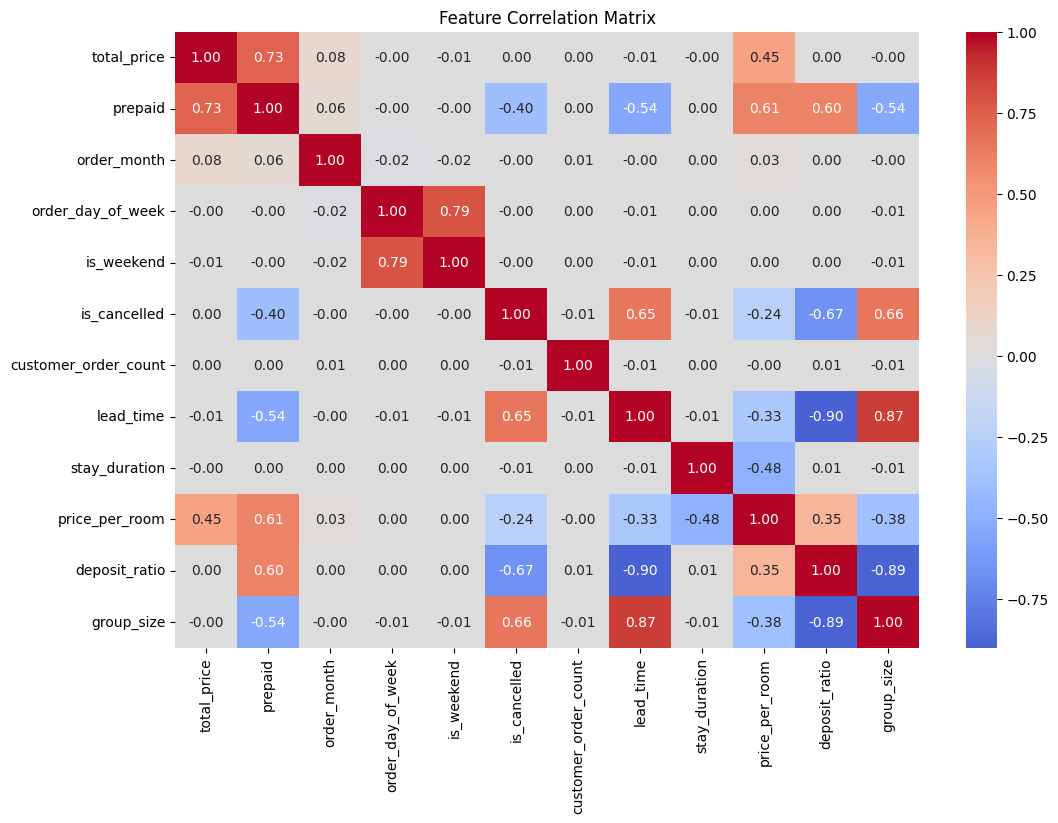

In [71]:
numerical_df = df
numerical_df.drop('brand_id', axis=1, inplace=True)
numerical_df.drop('hotel_id', axis=1, inplace=True)

plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()